# Visualization and loading dataset

## load data of participant data

In [29]:
import csv
import numpy as np

from load_subject import load_subject_data


In [30]:
# Create an empty list to store the dictionaries
participants_info = []
subjects = []

# Open the file in read mode
with open('../participants.tsv', 'r') as f:
    # Create a DictReader object with tab as the delimiter
    reader = csv.DictReader(f, delimiter='\t')
    # Iterate over the rows of the reader
    for row in reader:
        # Append each row as a dictionary to the list
        participants_info.append(row)

# Print the list of dictionaries
print(participants_info[0])


{'participant_id': 'sub-001', 'Original_ID': '8010', 'Group': 'CTL', 'sess1_Med': 'n/a', 'sess2_Med': 'no s2', 'sex': 'Female', 'age': '61'}


In [31]:
subjects.append(load_subject_data(0, participants_info))
subjects.append(load_subject_data(1, participants_info))
subjects.append(load_subject_data(2, participants_info))

Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-001\ses-01\eeg\sub-001_ses-01_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-002\ses-01\eeg\sub-002_ses-01_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-002\ses-02\eeg\sub-002_ses-02_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


In [32]:
events_types = set(subjects[0]['events']['type'])
print((events_types))

{'Instr: "Match"', 'FB: "No Match"', 'FB: 0', 'STATUS', 'Imperative Stimulus', 'FB: "Too Slow"', 'Right Button Choice', 'FB: +1', 'Instr: "Choose"', 'Left Button Choice'}


In [33]:
print(subjects[0]["EEG"].shape)

(67, 704900)


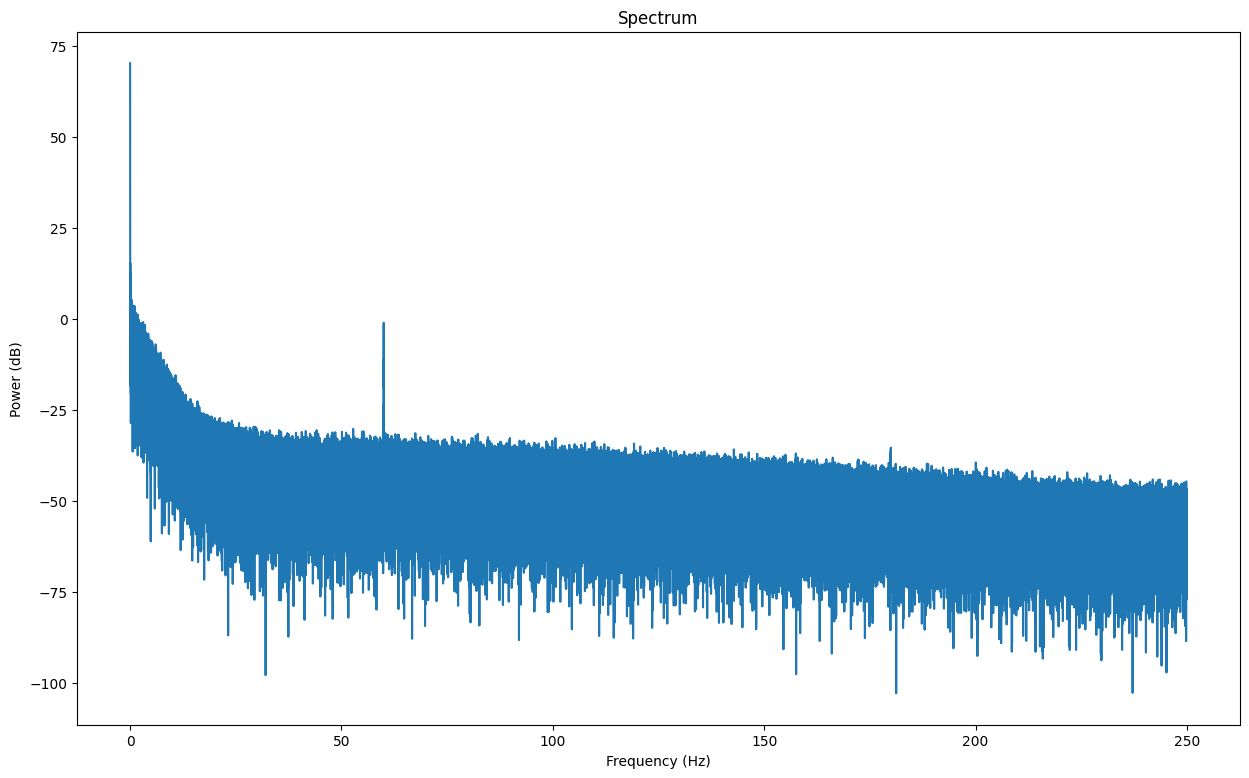

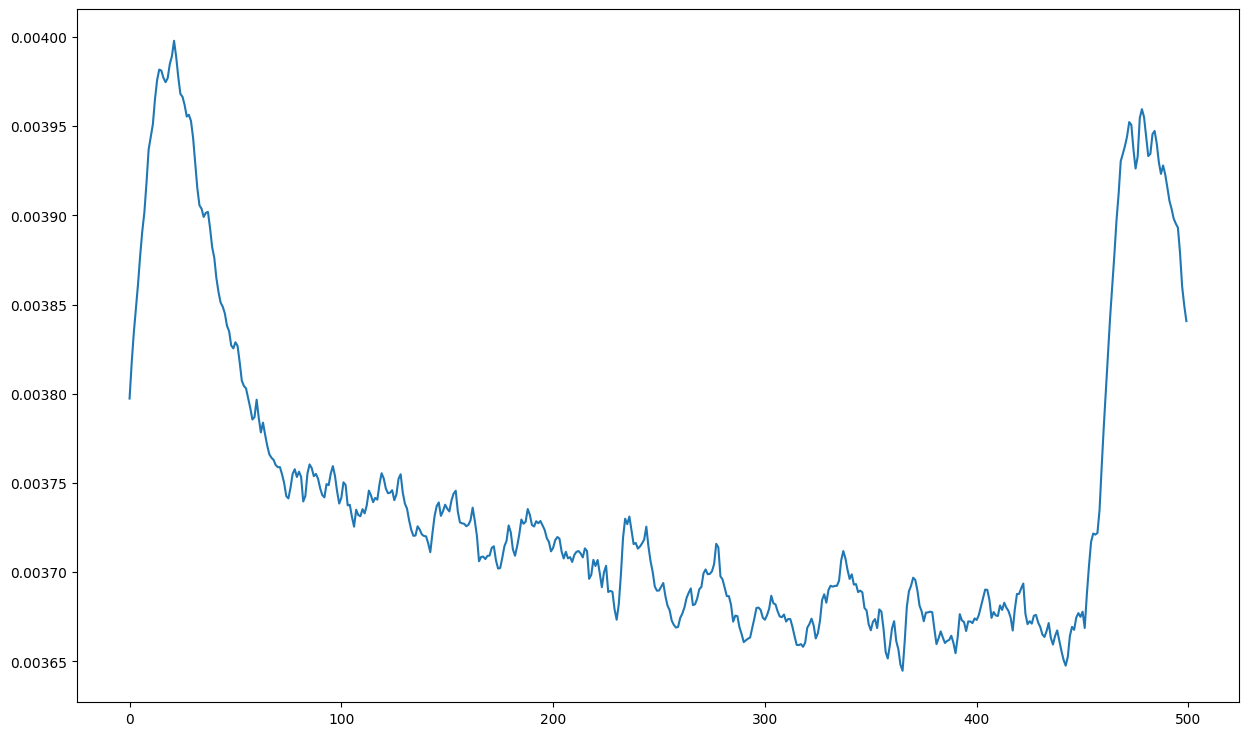

In [34]:
# filter data

import matplotlib.pyplot as plt
from signal_processing import plot_spectrum

fs = 500
plot_spectrum(subjects[0]["EEG"][0,:], fs)

plt.figure
plt.plot(subjects[0]["EEG"][0,0:fs])

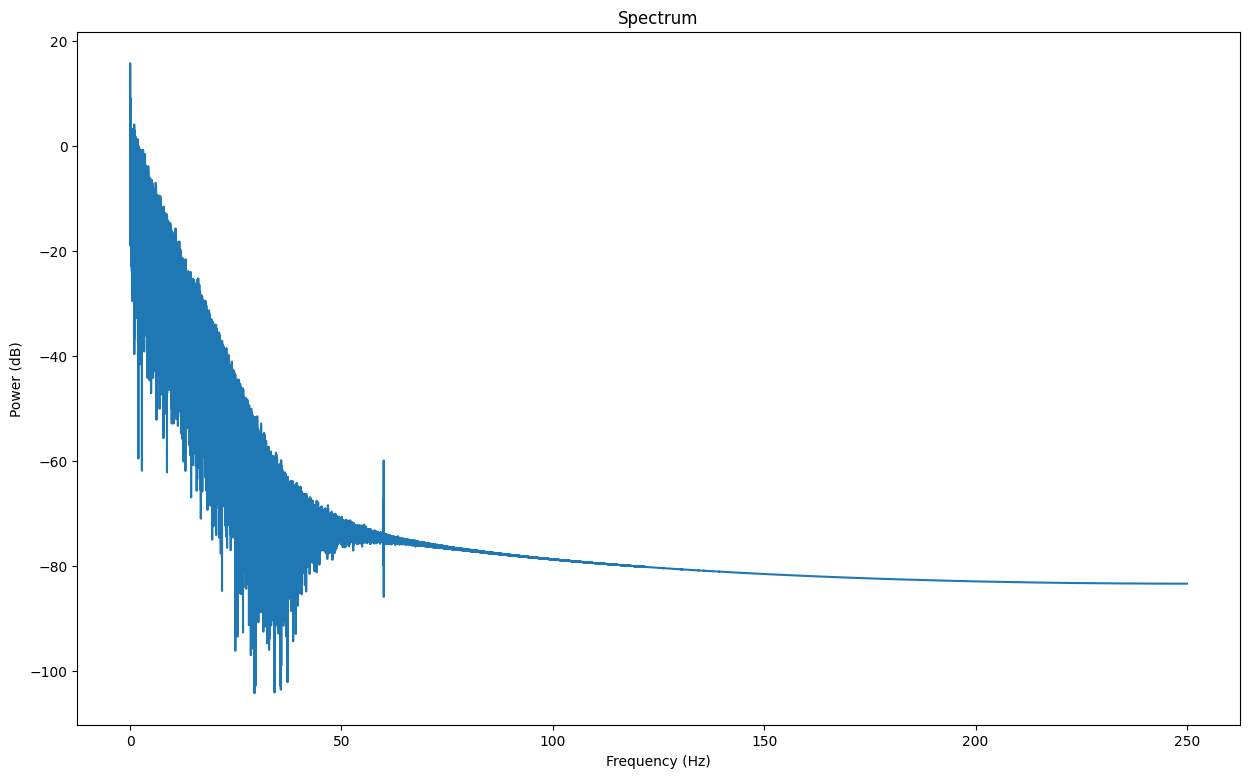

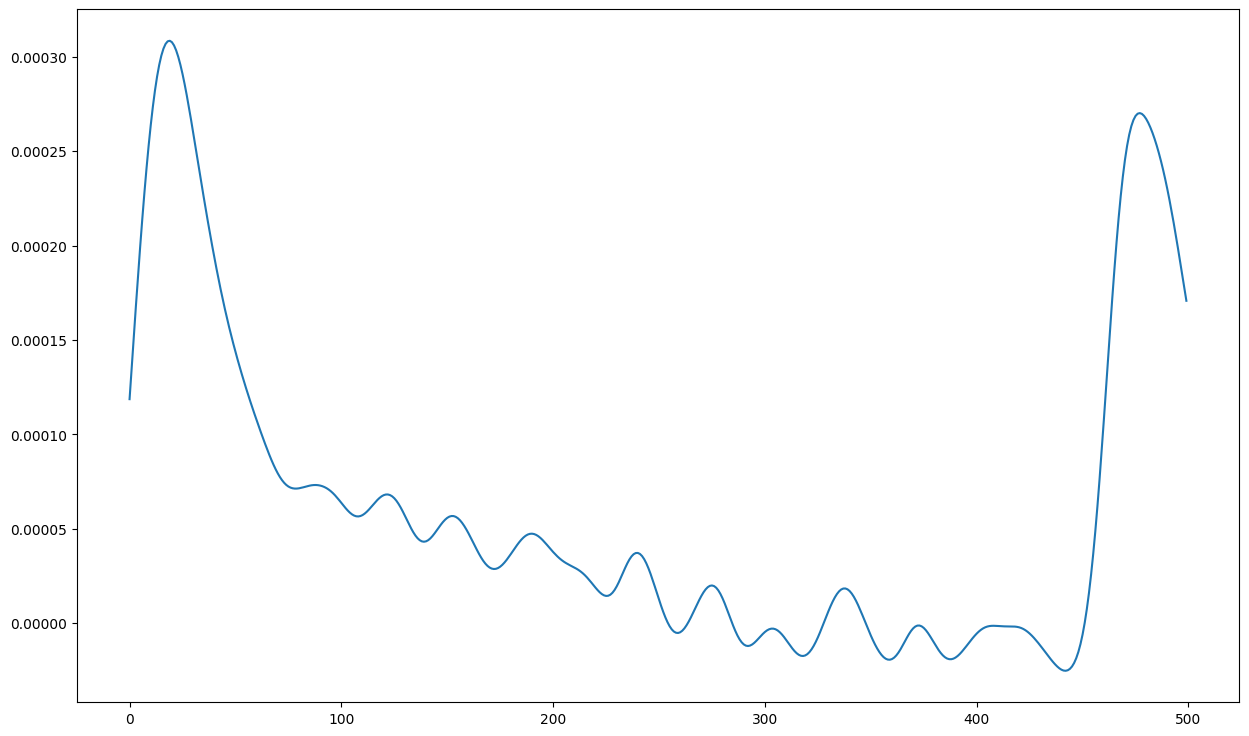

In [35]:
from signal_processing import bp_filter

subjects[0]["EEG"] = bp_filter(subjects[0]["EEG"], 0.01, 20, 3, fs)

plot_spectrum(subjects[0]["EEG"][0,:], fs)

plt.figure
plt.plot(subjects[0]["EEG"][0,0:fs])

In [36]:
subjects[1]["EEG"] = bp_filter(subjects[1]["EEG"], 0.01, 20, 3, fs)
subjects[2]["EEG"] = bp_filter(subjects[2]["EEG"], 0.01, 20, 3, fs)

c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


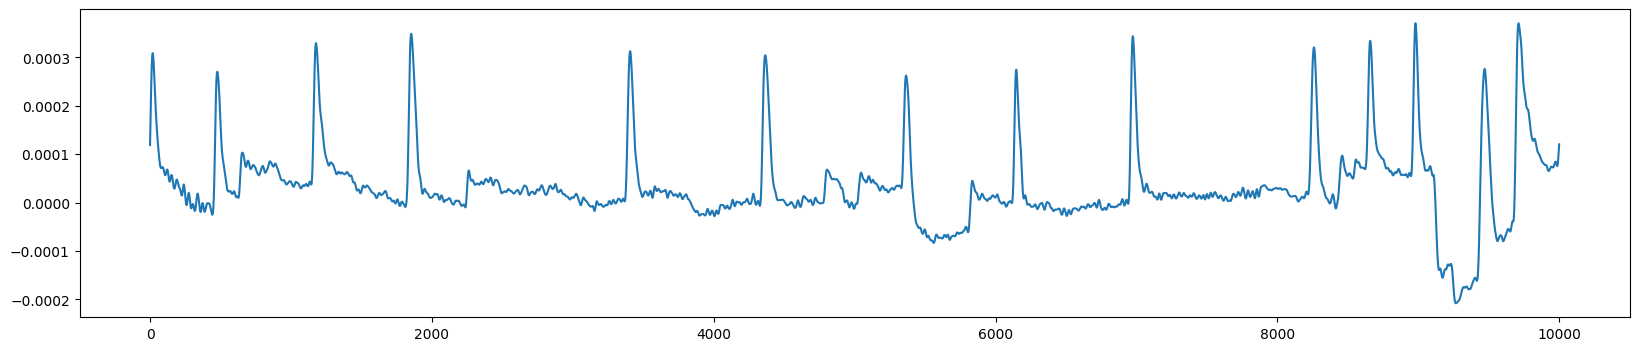

In [37]:
from sklearn.decomposition import FastICA

X = subjects[0]["EEG"][:,0:20*fs].T

# plot original data
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X.T[0,:])

# Run ICA on your data
ica = FastICA(n_components=X.shape[1]) # we want *all* the components
ica.fit(X)

# Decompose your data into independent components
components = ica.transform(X) # shape = (n_samples, n_components)


(10000, 67)


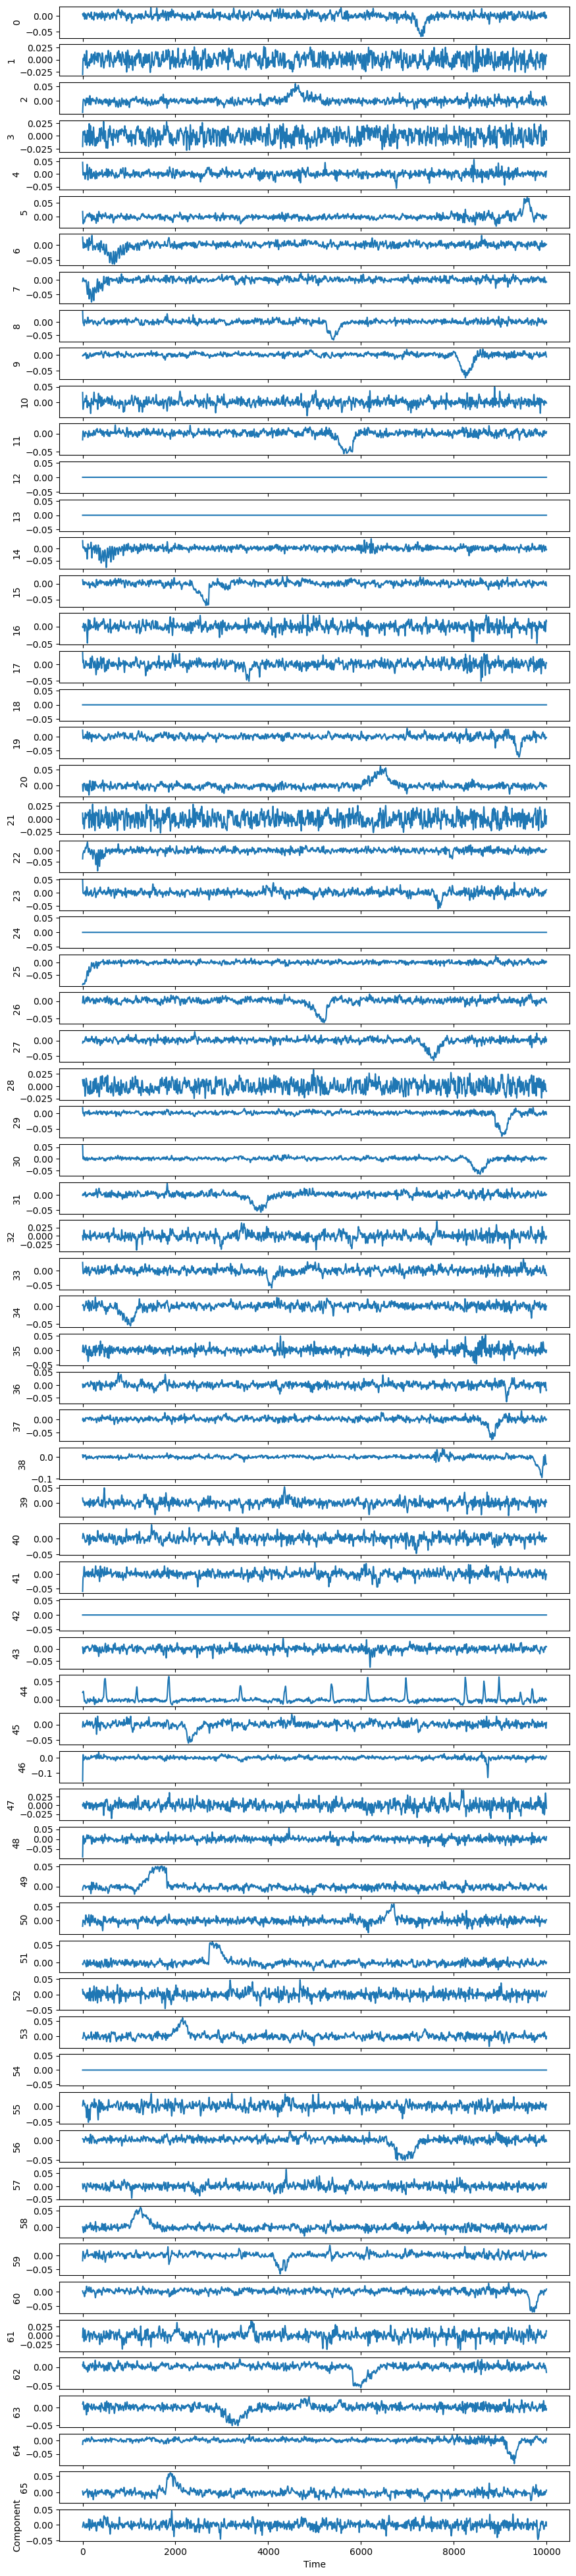

In [66]:
# Plot the components and inspect them visually to identify the ones that contain eye blinks or other artifacts
print(components.shape)
plt.figure()
plt.rcParams['figure.figsize'] = (10,50)

for i in range(components.shape[1]):    
    plt.subplot(components.shape[1], 1, i+1)
    plt.plot(components.T[i,:])
    plt.ylabel(i)
    
plt.xlabel('Time')
plt.ylabel('Component')
plt.show()

In [39]:
print(np.max(components, 0) > 0.07)
print(np.where(np.max(components, 0) > 0.07))

[False False False False False False False False False False False False
  True  True False False False False  True False False False False False
  True False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False  True False False False False False
 False False False False False False False]
(array([12, 13, 18, 24, 42, 54], dtype=int64),)


In [40]:
remove_indices = list(np.where(np.max(components, 0) > 0.07))  # pretend the user selected components 0, 1, and 3

# "remove" unwanted components by setting them to 0 - simplistic but gets the job done
components[:, remove_indices] = 0

#reconstruct signal
X_restored = ica.inverse_transform(components)

(10000, 67)


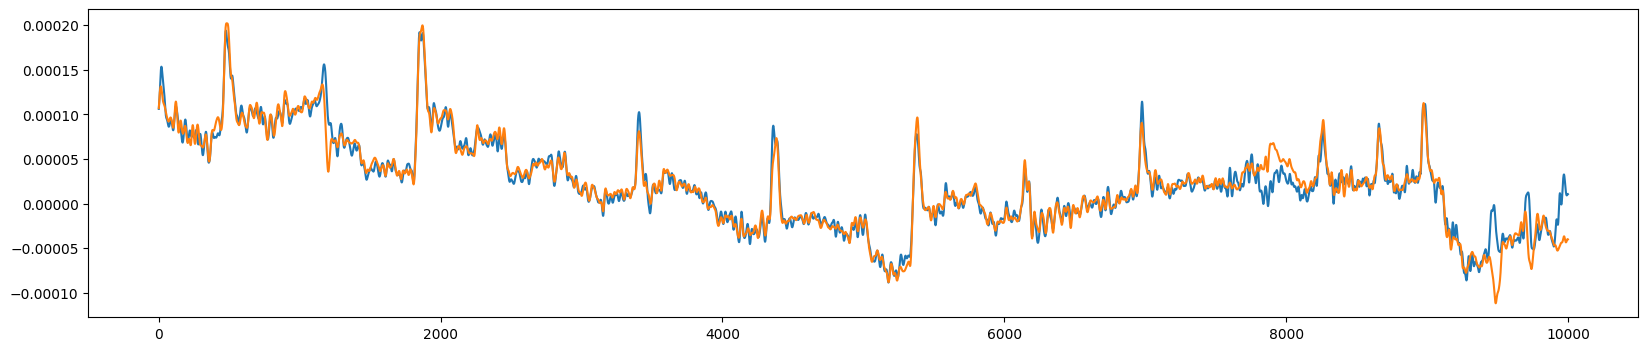

In [41]:
print(X_restored.shape)

plt.figure
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X_restored.T[3,:])

plt.figure
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X.T[3,:])


In [58]:
from signal_processing import remove_ICA
subjects[0]["EEG"] = remove_ICA(subjects[0]["EEG"], 0.08)
subjects[1]["EEG"] = remove_ICA(subjects[1]["EEG"], 0.08)
subjects[2]["EEG"] = remove_ICA(subjects[2]["EEG"], 0.08)

c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:550: UserWarning: n_components is too large: it will be set to 67
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:550: UserWarning: n_components is too large: it wil

In [43]:
from preprocess import cluster_events_by_type

sub1_events_clus = cluster_events_by_type(subjects[0]['events']['onset'], subjects[0]['events']['type'])

del sub1_events_clus['STATUS']

print(sub1_events_clus['Instr: "Match"'])

['172.2900000000' '192.9380000000' '201.1120000000' '267.4960000000'
 '274.9840000000' '295.3500000000' '306.5080000000' '318.3180000000'
 '323.5380000000' '340.5180000000' '345.8720000000' '362.1680000000'
 '367.5880000000' '378.9300000000' '390.1060000000' '406.6180000000'
 '411.9060000000' '423.4820000000' '440.6620000000' '452.2860000000'
 '464.1620000000' '475.4040000000' '486.4460000000' '491.8840000000'
 '506.1940000000' '523.3240000000' '528.9280000000' '546.0920000000'
 '551.7620000000' '563.1560000000' '574.8640000000' '592.3280000000'
 '604.2540000000' '609.9400000000' '621.0660000000' '632.4580000000'
 '644.0340000000' '655.7260000000' '673.3560000000' '678.7940000000'
 '689.9520000000' '707.2480000000' '712.7040000000' '724.4960000000'
 '739.2740000000' '750.4160000000' '761.9240000000' '779.4540000000'
 '784.8740000000' '795.8500000000' '812.9960000000' '818.3180000000'
 '835.9980000000' '846.7900000000' '852.3440000000' '869.8900000000'
 '875.2940000000' '886.5700000000'

In [44]:
from preprocess import cluster_events_by_type

sub2_events_clus = cluster_events_by_type(subjects[1]['events']['onset'], subjects[1]['events']['type'])

del sub2_events_clus['STATUS']

print(sub2_events_clus['Instr: "Match"'])

['227.3620000000' '243.6580000000' '249.1960000000' '327.3060000000'
 '338.6640000000' '343.5520000000' '353.9600000000' '359.7980000000'
 '375.8760000000' '380.8640000000' '391.5220000000' '396.7260000000'
 '401.6460000000' '412.1700000000' '422.6460000000' '433.2040000000'
 '444.0960000000' '454.9040000000' '460.0900000000' '471.0160000000'
 '487.1440000000' '492.4320000000' '503.1580000000' '519.1860000000'
 '524.5560000000' '535.0480000000' '546.4240000000' '561.4520000000'
 '578.3480000000' '583.5860000000' '600.2140000000' '604.9520000000'
 '615.5600000000' '620.2800000000' '631.2060000000' '636.8420000000'
 '642.1640000000' '652.7380000000' '668.8000000000' '679.8260000000'
 '684.7300000000' '695.6220000000' '706.8300000000' '712.5180000000'
 '723.7420000000' '729.0800000000' '745.4760000000' '757.0680000000'
 '762.4560000000' '773.7800000000' '790.3100000000' '795.5640000000'
 '809.7580000000' '820.4660000000' '831.4260000000' '842.5500000000'
 '854.1600000000' '866.3360000000'

In [45]:
from preprocess import cluster_events_by_type

sub3_events_clus = cluster_events_by_type(subjects[2]['events']['onset'], subjects[2]['events']['type'])

del sub3_events_clus['STATUS']

print(sub3_events_clus['Instr: "Match"'])

['90.3360000000' '109.1160000000' '114.4700000000' '166.0100000000'
 '177.8020000000' '183.2720000000' '194.8660000000' '212.2460000000'
 '217.6000000000' '229.9080000000' '241.5000000000' '258.9980000000'
 '264.5520000000' '281.5640000000' '287.0860000000' '304.1160000000'
 '315.0080000000' '326.1160000000' '331.5700000000' '342.8780000000'
 '360.1580000000' '371.7340000000' '377.3380000000' '396.3360000000'
 '412.7980000000' '423.7400000000' '429.1780000000' '440.1540000000'
 '451.5120000000' '468.5420000000' '474.0460000000' '484.8700000000'
 '496.5800000000' '508.3380000000' '519.5980000000' '525.2180000000'
 '536.4440000000' '553.3240000000' '558.8600000000' '570.2360000000'
 '587.1500000000' '592.4700000000' '609.2500000000' '614.8040000000']


In [46]:
from preprocess import cluster_and_epoch

fs = 500
epoch_limits = np.array([-0.3, 1])
baseline_limits = np.array([-0.2, 0])
cluster_and_epoch(subjects[0], sub1_events_clus, fs, epoch_limits, baseline_limits)
cluster_and_epoch(subjects[1], sub2_events_clus, fs, epoch_limits, baseline_limits)
cluster_and_epoch(subjects[2], sub3_events_clus, fs, epoch_limits, baseline_limits)


In [47]:
print(subjects[0]['epochs']['Left Button Choice'].shape)
print(subjects[1]['epochs']['Left Button Choice'].shape)
print(subjects[2]['epochs']['Left Button Choice'].shape)

(67, 651, 148)
(67, 651, 143)
(67, 651, 49)


In [53]:
# calculate and plot ERPs

from preprocess import calc_ERP

calc_ERP(subjects[0])
calc_ERP(subjects[1])
calc_ERP(subjects[2])

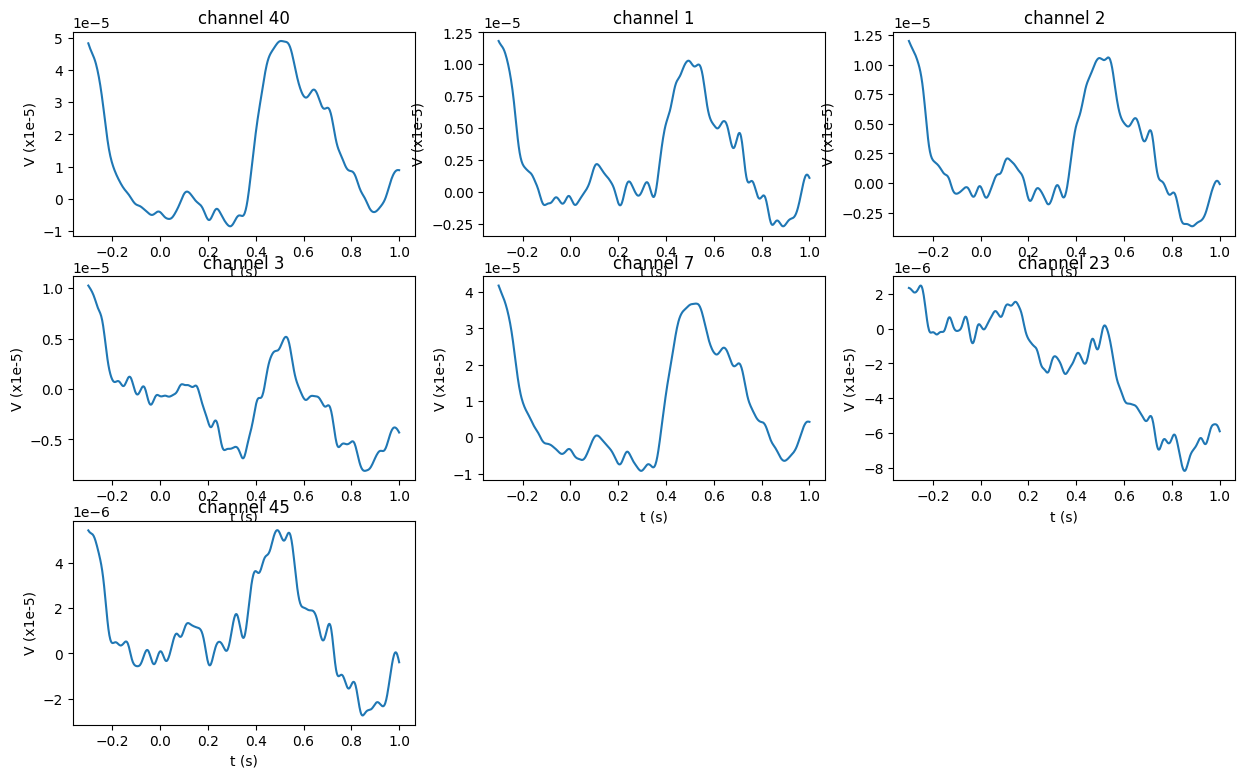

In [59]:
from preprocess import plot_ERP

plot_ERP(subjects[0]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

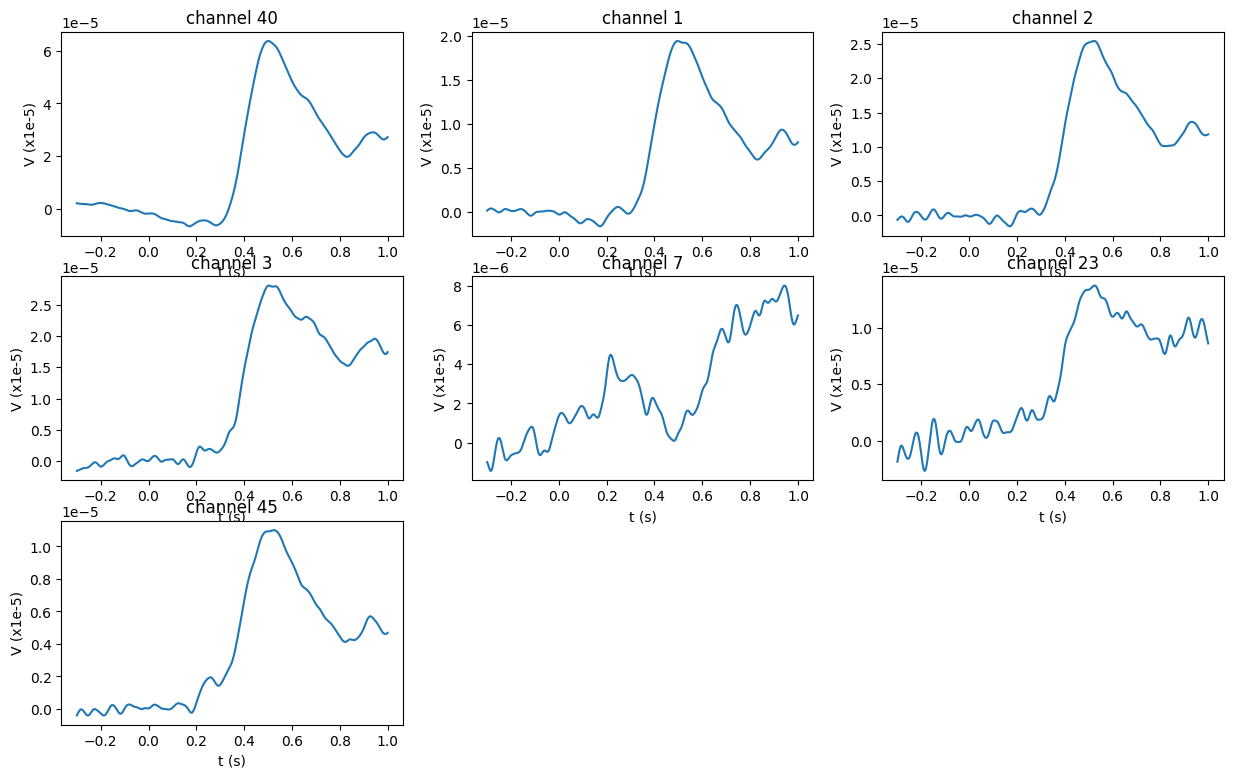

In [60]:
plot_ERP(subjects[1]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

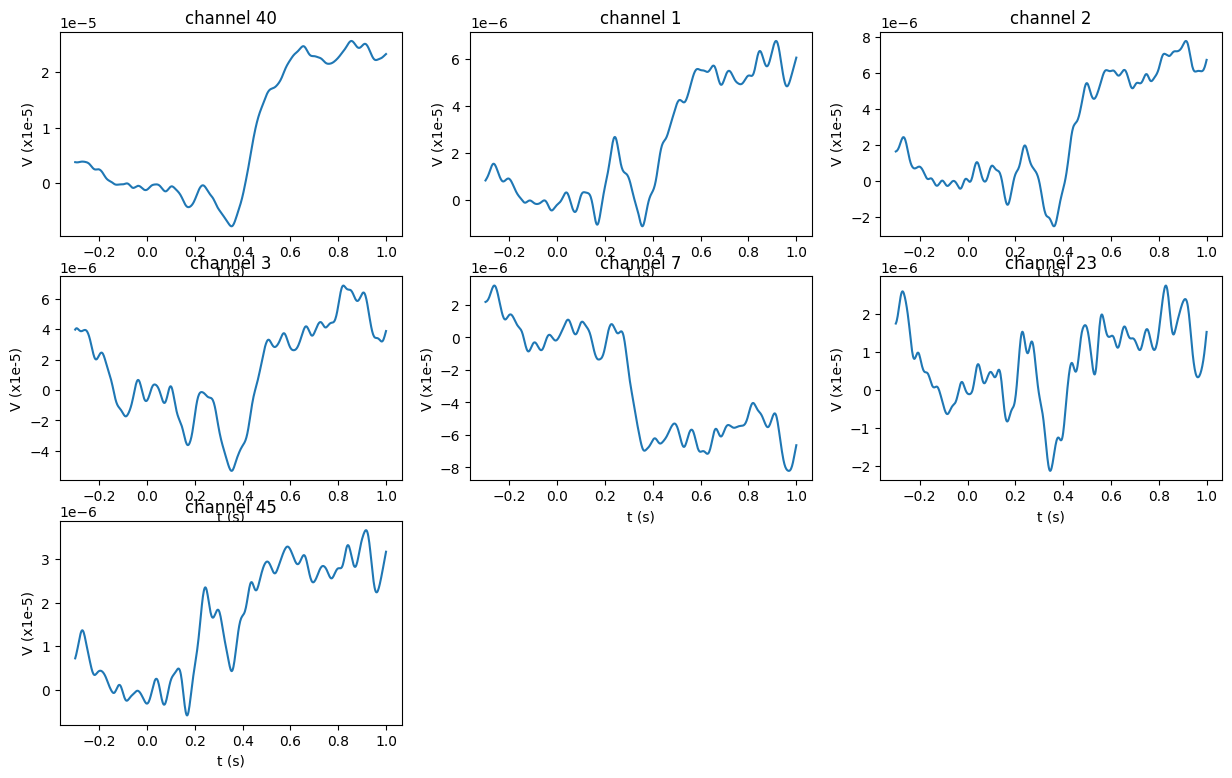

In [61]:
plot_ERP(subjects[2]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

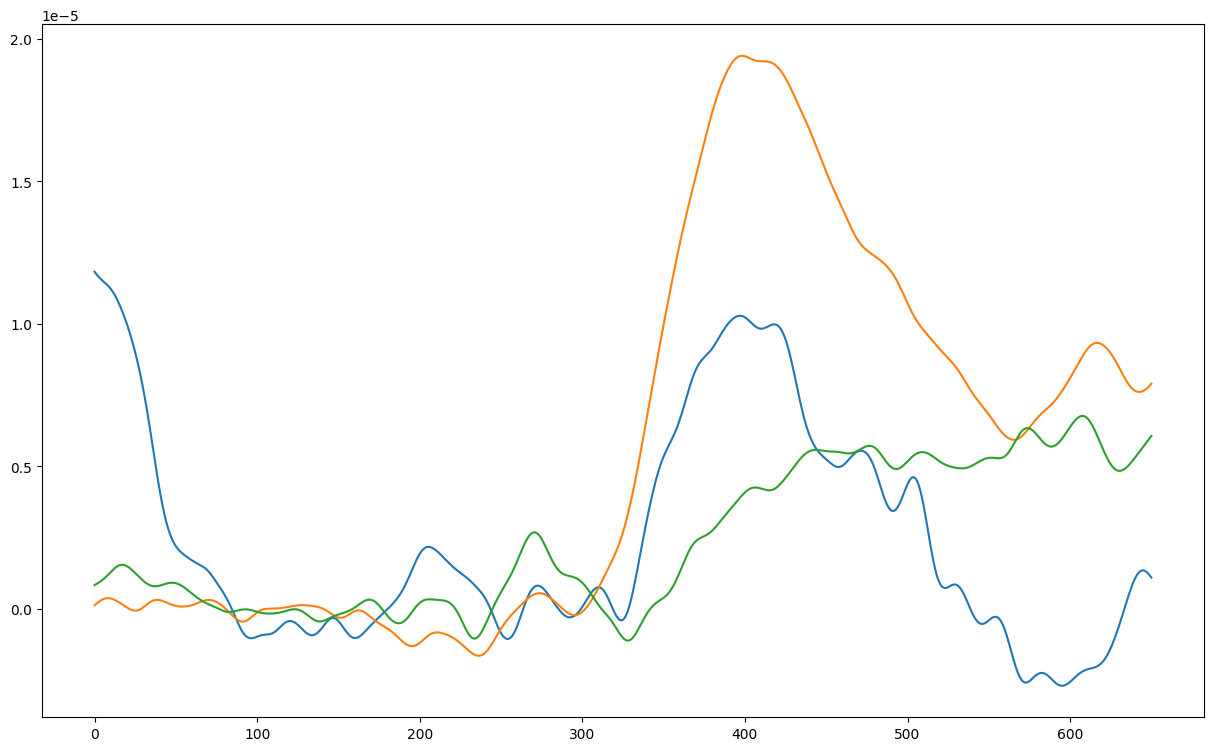

In [64]:
plt.figure
plt.plot(subjects[0]['ERP']['FB: +1'][1,:])
plt.plot(subjects[1]['ERP']['FB: +1'][1,:])
plt.plot(subjects[2]['ERP']['FB: +1'][1,:])